# Clouds

##### A GWDST project to analyze and visualize modeled cloud features, particularly variability and extremes.

### Input and data

In [16]:
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
import seaborn as sns
#import cartopy.crs as ccrs

from dask.distributed import Client

sns.set(context='talk', palette='colorblind', style='ticks')

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:55557 Dashboard: http://127.0.0.1:8787,Cluster Workers: 72 Cores: 72 Memory: 40.38 GB


In [40]:
ds = xr.open_mfdataset('/glade/scratch/mcamron/archive/f.c54120.FWscHIST.f09_f09.gwdst/atm/hist/f.c54120.FWscHIST.f09_f09.gwdst.cam.h1.2002-07-*.nc')
ds = ds.sel(lat=slice(-20,20))
ds

<xarray.Dataset>
Dimensions:          (ilev: 71, lat: 42, lev: 70, lon: 288, nbnd: 2, time: 744)
Coordinates:
  * lat              (lat) float64 -19.32 -18.38 -17.43 -16.49 -15.55 -14.61 ...
  * lon              (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * lev              (lev) float64 5.96e-06 9.827e-06 1.62e-05 2.671e-05 ...
  * ilev             (ilev) float64 4.5e-06 7.42e-06 1.223e-05 2.017e-05 ...
  * time             (time) datetime64[ns] 2002-07-01 2002-07-01T00:59:59 ...
Dimensions without coordinates: nbnd
Data variables:
    gw               (time, lat) float64 0.01552 0.01561 0.01569 0.01577 ...
    hyam             (time, lev) float64 5.96e-09 9.827e-09 1.62e-08 ...
    hybm             (time, lev) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    P0               (time) float64 1e+05 1e+05 1e+05 1e+05 1e+05 1e+05 ...
    hyai             (time, ilev) float64 4.5e-09 7.42e-09 1.223e-08 ...
    hybi             (time, ilev) float64 0.0 0.0 0.0 0.0 0.0 0.

In [8]:
pconvt = -7000 * np.log(ds['PCONVT'] / ds['PS'])    # Converting from pressure to height estimate

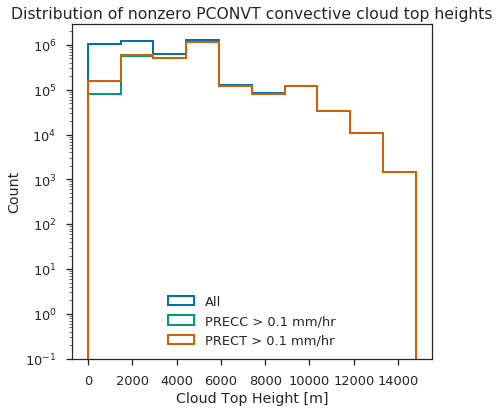

In [32]:
f, ax = plt.subplots(figsize=(7,6))

pcbins = np.linspace(0, pconvt.max().values, 11)
pconvt.where(pconvt > 0).plot.hist(ax=ax, bins=pcbins, log=True, histtype='step', linewidth=2, label='All')
pconvt.where((ds['PRECC']*3.6e6) > 0.1).plot.hist(ax=ax, bins=pcbins, log=True, histtype='step', linewidth=2, label='PRECC > 0.1 mm/hr')
pconvt.where((ds['PRECT']*3.6e6) > 0.1).plot.hist(ax=ax, bins=pcbins, log=True, histtype='step', linewidth=2, label='PRECT > 0.1 mm/hr')

ax.legend(loc='lower center')
ax.set_title('Distribution of nonzero PCONVT convective cloud top heights')
ax.set_xlabel('Cloud Top Height [m]')

plt.tight_layout()    
f.savefig('../figures/clouds/dist_pconvt.png')

### Investigating CLOUDFRAC_CLUBB
First, looking at distribution of all cloud fractions

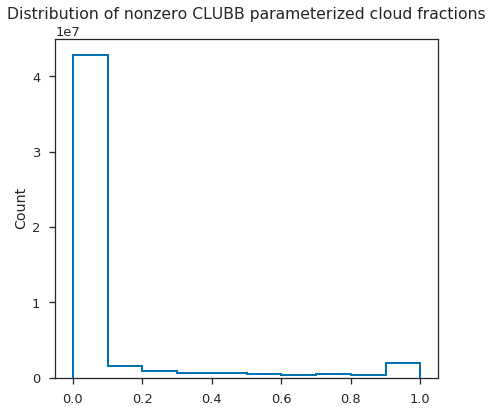

In [33]:
f, ax = plt.subplots(figsize=(7,6))

(ds['CLOUDFRAC_CLUBB'].where(ds['CLOUDFRAC_CLUBB'] > 0)).plot.hist(ax=ax, histtype='step', linewidth=2)
ax.set_title('Distribution of nonzero CLUBB parameterized cloud fractions', y=1.04)
plt.tight_layout()

f.savefig('../figures/clouds/dist_cloudfracclubb.png')

Looking at heights of all nonzero CLUBB cloudfractions

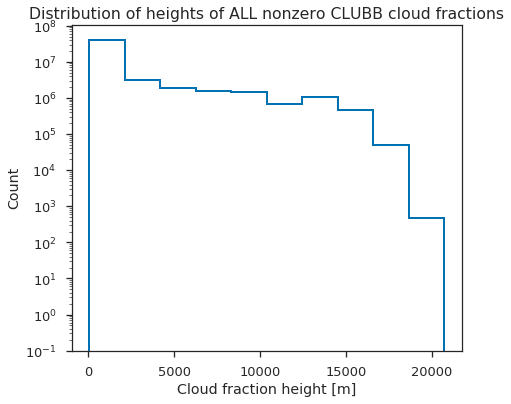

In [35]:
f, ax = plt.subplots(figsize=(7,6))

(xu.log(ds['lev'] / 1000) * -7000).where(ds['CLOUDFRAC_CLUBB'] > 0).plot.hist(log=True, histtype='step', linewidth=2)
ax.set_title('Distribution of heights of ALL nonzero CLUBB cloud fractions')
ax.set_xlabel('Cloud fraction height [m]')

f.savefig('../figures/clouds/dist_CFC_all.png')

Does `CLOUDFRAC_CLUBB` actually include ZM clouds? Investigating `club_intr.F90` shows not so, but `CLOUDCOVER_CLUBB` may.

#### Finding max `lev` indices of `CLOUDFRAC_CLUBB > 0`

In [51]:
ccstack = ds['CLOUDFRAC_CLUBB'].stack(xyt=('time', 'lat', 'lon'))
indmax = np.array(ccstack.values.nonzero())
ccstack

<xarray.DataArray 'CLOUDFRAC_CLUBB' (lev: 70, xyt: 8999424)>
dask.array<reshape, shape=(70, 8999424), dtype=float32, chunksize=(70, 290304)>
Coordinates:
  * lev      (lev) float64 5.96e-06 9.827e-06 1.62e-05 2.671e-05 4.404e-05 ...
  * xyt      (xyt) MultiIndex
  - time     (xyt) datetime64[ns] 2002-07-01 2002-07-01 2002-07-01 ...
  - lat      (xyt) float64 -19.32 -19.32 -19.32 -19.32 -19.32 -19.32 -19.32 ...
  - lon      (xyt) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
Attributes:
    mdims:      1
    units:      fraction
    long_name:  Cloud Fraction